In [4]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import psutil
import tensorflow as tf
from scipy.stats import pearsonr
from tensorflow.keras.layers import Dense, Input, LeakyReLU
from tensorflow.keras.models import Model

from modules.training.normlayer import NormalizeLayer
from modules.training.phase_manager import IsTraining

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

from modules.training.cme_modeling import ModelBuilder as MB

C:\Users\the_3\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\the_3\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

In [5]:
from modules.training.phase_manager import TrainingPhaseManager

# instantiate the model_builder
mb = MB()
pm = TrainingPhaseManager()  # Training phase manager

In [3]:
def benchmark_function(func, args=(), kwargs=None, num_runs=100):
    """
    Generic benchmark utility for any function.
    
    :param func: Function to benchmark
    :param args: Tuple of positional arguments for the function
    :param kwargs: Dictionary of keyword arguments for the function
    :param num_runs: Number of runs for averaging timing
    :return: Dictionary containing timing and memory statistics
    """
    if kwargs is None:
        kwargs = {}
    global result
    process = psutil.Process(os.getpid())
    execution_times = []
    memory_usages = []

    # Warmup run
    _ = func(*args, **kwargs)

    # Clear any cached memory
    tf.keras.backend.clear_session()

    for _ in range(num_runs):
        mem_before = process.memory_info().rss / 1024 / 1024

        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()

        mem_after = process.memory_info().rss / 1024 / 1024

        execution_times.append(end_time - start_time)
        memory_usages.append(mem_after - mem_before)

        tf.keras.backend.clear_session()

    times_ms = np.array(execution_times) * 1000
    memory_mb = np.array(memory_usages)

    return {
        'time_mean_ms': np.mean(times_ms),
        'time_std_ms': np.std(times_ms),
        'memory_mean_mb': np.mean(memory_mb),
        'memory_max_mb': np.max(memory_mb),
        'last_result': result
    }

In [5]:
y_true = tf.constant([[1.0],
                      [5.0],
                      [0.0]])

z_pred = tf.constant([[1.0, 1.0],
                      [2.0, -1.0],
                      [3.0, 1.0]])

# print shapes
print(f"y_true shape: {y_true.shape}")
print(f"z_pred shape: {z_pred.shape}")

y_true shape: (3, 1)
z_pred shape: (3, 2)


In [6]:
res = mb.pds_loss_vec(y_true, z_pred, pm)
print(f'Result: {res.numpy():.4f}')

Result: 176.6667


In [7]:
res = mb.pds_loss_linear_vec(y_true, z_pred, pm)
print(f'Result: {res.numpy():.4f}')

Result: 176.6667


In [8]:
res = mb.pdc_loss_vec(y_true, z_pred, pm)
print(f'Result: {res.numpy():.4f}')

Result: 0.0714


In [9]:
res = mb.pdc_loss_linear_vec(y_true, z_pred, pm)
print(f'Result: {res.numpy():.4f}')

Result: 0.0714


In [10]:
# Parameters
num_points = 5000  # 201 points for labels from -100 to 100 inclusive

# Create evenly spaced labels from -100 to 100
labels = np.linspace(-5000, 5000, num_points)
# update the dimension of labels
labels = np.expand_dims(labels, axis=1)

# Generate points like (0, 0), (1, 1), ..., (200, 200)
points = np.array([(i, i) for i in range(num_points)])

# convert to tensor float32
labels = tf.constant(labels, dtype=tf.float32)
points = tf.constant(points, dtype=tf.float32)

print(f"Labels shape: {labels.shape}")
print(f"Points shape: {points.shape}")

# Random sample weights between 0 and 1
sample_weights = np.random.rand(num_points)

Labels shape: (5000, 1)
Points shape: (5000, 2)


In [11]:
stats = benchmark_function(
    mb.pds_loss_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: 166966887186432.0000
Time: 52.995 ± 16.855 ms
Memory peak: 0.082 MB


In [12]:
stats = benchmark_function(
    mb.pds_loss_linear_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: 250350204354560.0000
Time: 34.857 ± 11.271 ms
Memory peak: 0.062 MB


In [13]:
stats = benchmark_function(
    mb.pdc_loss_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: 0.0000
Time: 149.464 ± 15.899 ms
Memory peak: 0.062 MB


In [17]:
stats = benchmark_function(
    mb.pdc_loss_linear_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: -0.0000
Time: 40.952 ± 15.438 ms
Memory peak: 0.004 MB


In [25]:
class Trainer:
    def __init__(self, input_dim=2, hidden_dims=None, output_dim=2):
        if hidden_dims is None:
            hidden_dims = [64, 32]
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.phase_manager = TrainingPhaseManager()
        self.model = self.build_model()

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs

        # Hidden layers with Leaky ReLU activation
        for dim in self.hidden_dims:
            x = Dense(dim)(x)
            x = LeakyReLU()(x)

        # Output layer
        outputs = Dense(self.output_dim)(x)
        outputs = NormalizeLayer(name='normalize_layer')(outputs)
        model = Model(inputs=inputs, outputs=outputs)
        return model

    def generate_synthetic_data(self, num_points=200):
        # Generate labels from -100 to 100
        labels = np.linspace(-1, 1, num_points)
        labels = np.expand_dims(labels, axis=1)

        # Generate input features (random noise + signal)
        noise = np.random.normal(0, 0.02, (num_points, self.input_dim))
        signal = np.repeat(labels, self.input_dim, axis=1)
        features = 0.3 * signal + 0.7 * noise

        return features, labels

    def compute_pairwise_correlation(self, features, predictions):
        """Compute pairwise correlation between features and predictions."""
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        # Flatten the distance matrices
        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        # Compute correlation
        correlation, _ = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation

    def train(self, loss_fn, epochs=1000, batch_size=32, verbose=1):
        # Generate synthetic data
        X_train, y_train = self.generate_synthetic_data(num_points=1000)

        # Compile model
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=loss_fn
        )

        # Convert to tf.data.Dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.batch(batch_size)

        # Training history
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose,
            callbacks=[IsTraining(self.phase_manager)]
        )

        # Final predictions
        predictions = self.model.predict(X_train)

        # Compute final correlation
        correlation = self.compute_pairwise_correlation(X_train, predictions)

        return history, correlation

    def plot_training_history(self, history):
        """Plot the training loss over epochs."""
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.title('Model Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    def plot_predictions(self, features, labels, predictions):
        """Plot original data and model predictions."""
        plt.figure(figsize=(12, 5))

        # Original data
        plt.subplot(1, 2, 1)
        plt.scatter(features[:, 0], features[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar()
        plt.title('Original Data')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

        # Predictions
        plt.subplot(1, 2, 2)
        plt.scatter(predictions[:, 0], predictions[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar()
        plt.title('Model Predictions')
        plt.xlabel('Embedding 1')
        plt.ylabel('Embedding 2')
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.tight_layout()
        plt.show()





In [24]:
# Usage example with custom loss function
def custom_loss(y_true, y_pred):
    return mb.pdc_loss_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


trainer = Trainer(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(loss_fn=custom_loss, epochs=int(1e3), batch_size=256)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=500)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

Epoch 1/1000
4/4 [==============================] - 1s 17ms/step - loss: 0.2992
Epoch 2/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1712
Epoch 3/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0532
Epoch 4/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.0431
Epoch 5/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.0268
Epoch 6/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0240
Epoch 7/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.0224
Epoch 8/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0211
Epoch 9/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0205
Epoch 10/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.0202
Epoch 11/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0199
Epoch 12/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.0195
Epoch 13/1000
4/4 [==================

KeyboardInterrupt: 

In [ ]:
# Usage example with custom loss function
def custom_loss(y_true, y_pred):
    return mb.pdc_loss_linear_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


trainer = Trainer(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(loss_fn=custom_loss, epochs=500, batch_size=256)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=500)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

In [11]:
class TrainerV2:
    def __init__(self, input_dim=2, hidden_dims=None, output_dim=2):
        if hidden_dims is None:
            hidden_dims = [64, 32]
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.phase_manager = TrainingPhaseManager()
        self.model = self.build_model()

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs
    
        # Hidden layers with Leaky ReLU activation
        for dim in self.hidden_dims:
            x = Dense(dim)(x)
            x = LeakyReLU()(x)
    
        # Output layer
        outputs = Dense(self.output_dim)(x)
        outputs = NormalizeLayer(name='normalize_layer')(outputs)
        model = Model(inputs=inputs, outputs=outputs)
        return model

    def generate_synthetic_data(self, num_points=200):
        """
        Generate synthetic data where:
        - Features are random 2D points with coordinates between 0 and 1
        - Labels are distances from origin (0,0)
        - Middle distances are ~10x more frequent than extremes
        """
        # Generate more points than needed for sampling
        pool_size = num_points * 10
        features = np.random.uniform(0, 1, (pool_size, self.input_dim))
        
        # Calculate distances
        distances = np.sqrt(np.sum(features**2, axis=1))
        
        # Create weights favoring middle distances
        # Use a gaussian centered at ~0.75 (middle of the possible range 0 to √2)
        weights = np.exp(-((distances - 0.75) ** 2) / (2 * 0.15 ** 2))
        
        # Normalize weights to probabilities
        weights = weights / np.sum(weights)
        
        # Sample indices according to weights
        selected_indices = np.random.choice(
            pool_size, 
            size=num_points, 
            p=weights,
            replace=False
        )
        
        # Select the points
        selected_features = features[selected_indices]
        selected_distances = distances[selected_indices]
        
        return selected_features, selected_distances.reshape(-1, 1)

    def compute_pairwise_correlation(self, features, predictions):
        """Compute pairwise correlation between features and predictions."""
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        # Flatten the distance matrices
        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        # Compute correlation
        correlation, _ = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation

    def train(self, loss_fn, epochs=1000, batch_size=32, verbose=1):
        # Generate synthetic data
        X_train, y_train = self.generate_synthetic_data(num_points=2000)

        # Compile model
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=loss_fn
        )

        # Convert to tf.data.Dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.batch(batch_size)

        # Training history
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose,
            callbacks=[IsTraining(self.phase_manager)]
        )

        # Final predictions
        predictions = self.model.predict(X_train)

        # Compute final correlation
        correlation = self.compute_pairwise_correlation(X_train, predictions)

        return history, correlation

    def plot_training_history(self, history):
        """Plot the training loss over epochs."""
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.title('Model Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    def plot_data_distribution(self, features, labels):
        """Plot the distribution of data points and their labels."""
        plt.figure(figsize=(15, 5))
        
        # Plot points in 2D space
        plt.subplot(1, 3, 1)
        scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
        plt.colorbar(scatter, label='Distance from Origin')
        plt.title('Data Points Colored by Distance')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        # Plot distance distribution
        plt.subplot(1, 3, 2)
        plt.hist(labels, bins=30, density=True)
        
        # Add the target distribution curve
        x = np.linspace(0, np.sqrt(2), 100)
        target_dist = np.exp(-((x - 0.75) ** 2) / (2 * 0.15 ** 2))
        target_dist = target_dist / np.max(target_dist) * plt.gca().get_ylim()[1]
        plt.plot(x, target_dist, 'r--', label='Target Distribution')
        plt.legend()
        
        plt.title('Distribution of Distances')
        plt.xlabel('Distance from Origin')
        plt.ylabel('Density')
        
        # Plot points with reference circles
        plt.subplot(1, 3, 3)
        plt.scatter(features[:, 0], features[:, 1], alpha=0.5)
        
        # Add quarter circles at different radii
        for radius in [0.25, 0.5, 0.75, 1.0]:
            circle = plt.Circle((0, 0), radius, fill=False, color='red', alpha=0.3)
            plt.gca().add_artist(circle)
        
        plt.axis('equal')
        plt.title('Points with Reference Circles')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

    def plot_predictions(self, features, labels, predictions):
        """Plot original data and model predictions."""
        plt.figure(figsize=(12, 5))

        # Original data
        plt.subplot(1, 2, 1)
        plt.scatter(features[:, 0], features[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='Distance from Origin')
        plt.title('Original Data')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

        # Predictions
        plt.subplot(1, 2, 2)
        plt.scatter(predictions[:, 0], predictions[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='Distance from Origin')
        plt.title('Model Predictions')
        plt.xlabel('Embedding 1')
        plt.ylabel('Embedding 2')
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.tight_layout()
        plt.show()

Epoch 1/500
2/2 [==============================] - 1s 10ms/step - loss: 0.0104
Epoch 2/500
2/2 [==============================] - 0s 9ms/step - loss: 0.0031
Epoch 3/500
2/2 [==============================] - 0s 9ms/step - loss: 0.0030
Epoch 4/500
2/2 [==============================] - 0s 9ms/step - loss: 0.0031
Epoch 5/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 6/500
2/2 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 7/500
2/2 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 8/500
2/2 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 9/500
2/2 [==============================] - 0s 9ms/step - loss: 0.0032
Epoch 10/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 11/500
2/2 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 12/500
2/2 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 13/500
2/2 [==============================] - 0s 8ms/s

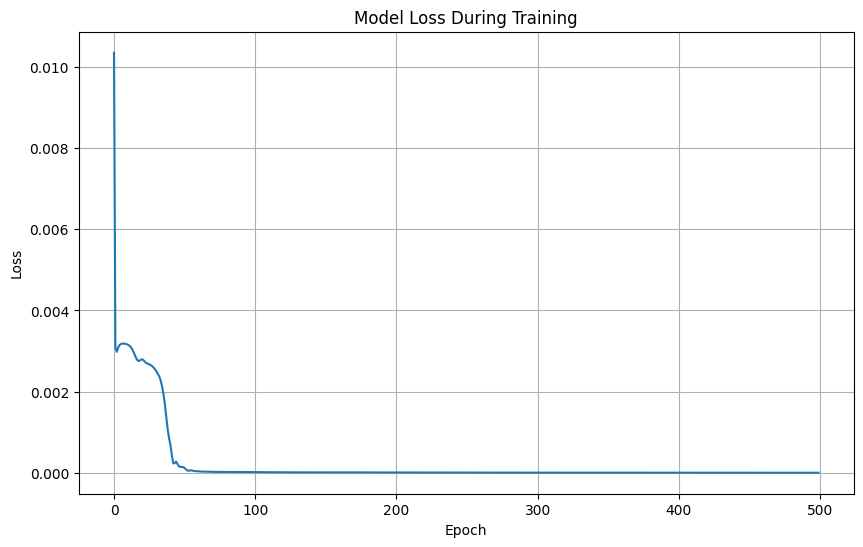

32/32 [==============================] - 0s 2ms/step


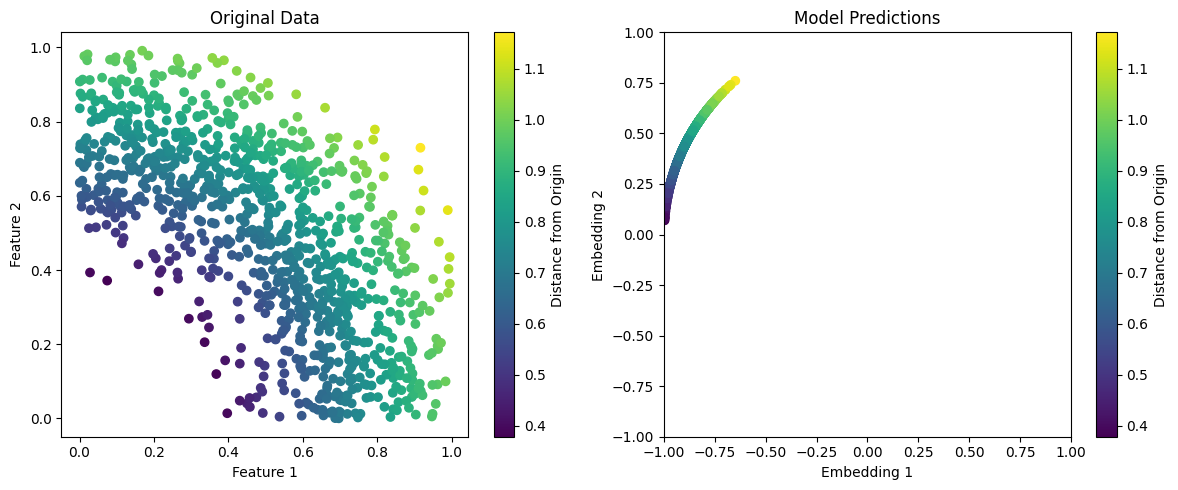

In [12]:
# Usage example with custom loss function
def custom_loss(y_true, y_pred):
    return mb.pds_loss_linear_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


trainer = TrainerV2(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(loss_fn=custom_loss, epochs=500, batch_size=1024)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)


Epoch 1/500
1/1 [==============================] - 1s 735ms/step - loss: 1.1755
Epoch 2/500
1/1 [==============================] - 0s 10ms/step - loss: 1.1226
Epoch 3/500
1/1 [==============================] - 0s 11ms/step - loss: 1.0268
Epoch 4/500
1/1 [==============================] - 0s 12ms/step - loss: 0.9509
Epoch 5/500
1/1 [==============================] - 0s 11ms/step - loss: 0.8769
Epoch 6/500
1/1 [==============================] - 0s 10ms/step - loss: 0.7751
Epoch 7/500
1/1 [==============================] - 0s 12ms/step - loss: 0.6797
Epoch 8/500
1/1 [==============================] - 0s 10ms/step - loss: 0.5508
Epoch 9/500
1/1 [==============================] - 0s 11ms/step - loss: 0.3929
Epoch 10/500
1/1 [==============================] - 0s 10ms/step - loss: 0.2580
Epoch 11/500
1/1 [==============================] - 0s 11ms/step - loss: 0.1707
Epoch 12/500
1/1 [==============================] - 0s 10ms/step - loss: 0.1171
Epoch 13/500
1/1 [==============================

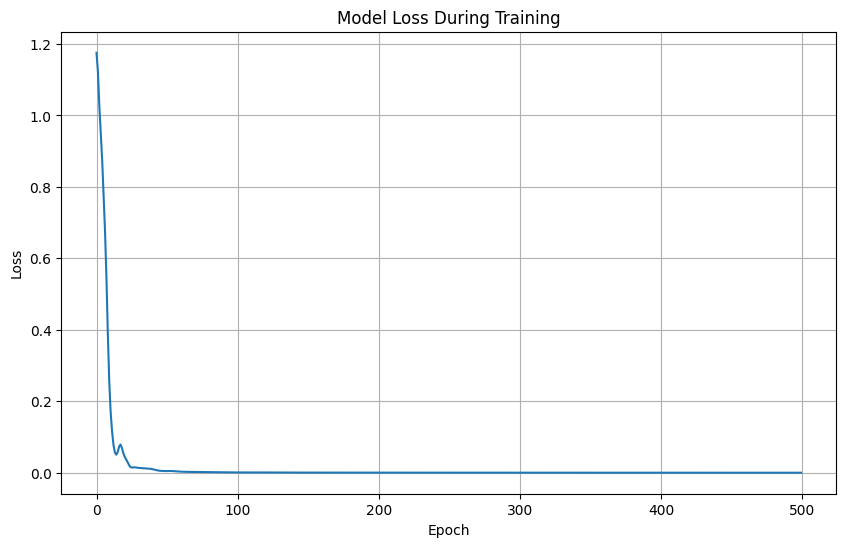

16/16 [==============================] - 0s 4ms/step


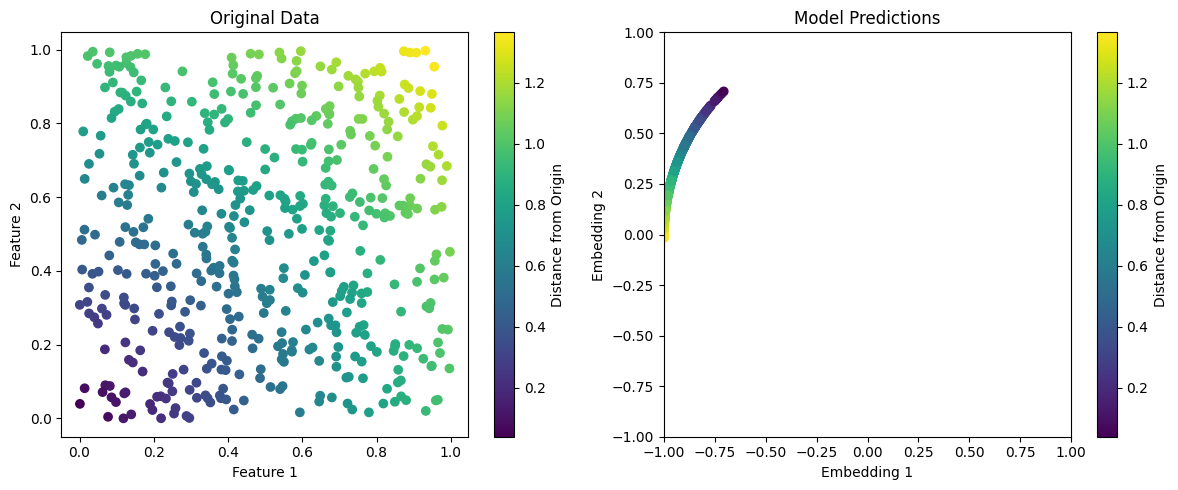

In [7]:
# Usage example with custom loss function
def custom_loss(y_true, y_pred):
    return mb.pdc_loss_linear_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


trainer = TrainerV2(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(loss_fn=custom_loss, epochs=500, batch_size=1024)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=500)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

In [6]:
class TrainerV2:
    def __init__(self, input_dim=2, hidden_dims=None, output_dim=2, ae=False):
        if hidden_dims is None:
            hidden_dims = [64, 32]
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.ae = ae
        self.phase_manager = TrainingPhaseManager()
        self.model = self.build_model()

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs
    
        # Hidden layers with Leaky ReLU activation
        for dim in self.hidden_dims:
            x = Dense(dim)(x)
            x = LeakyReLU()(x)
    
        # Output layer for normalized embedding
        embedding = Dense(self.output_dim)(x)
        normalized_embedding = NormalizeLayer(name='normalize_layer')(embedding)
        
        if self.ae:
            # Decoder layers - mirror the encoder architecture
            decoder_dims = self.hidden_dims[::-1]  # Reverse hidden dims
            x = normalized_embedding
            
            for dim in decoder_dims:
                x = Dense(dim)(x)
                x = LeakyReLU()(x)
            
            # Reconstruction output
            reconstruction = Dense(self.input_dim, activation='sigmoid')(x)
            
            model = Model(inputs=inputs, outputs=[normalized_embedding, reconstruction])
        else:
            model = Model(inputs=inputs, outputs=normalized_embedding)
            
        return model

    def generate_synthetic_data(self, num_points=200):
        """
        Generate synthetic data where:
        - Features are random 2D points with coordinates between 0 and 1
        - Labels are distances from origin (0,0)
        - Middle distances are ~10x more frequent than extremes
        """
        # Generate more points than needed for sampling
        pool_size = num_points * 10
        features = np.random.uniform(0, 1, (pool_size, self.input_dim))
        
        # Calculate distances
        distances = np.sqrt(np.sum(features**2, axis=1))
        
        # Create weights favoring middle distances
        weights = np.exp(-((distances - 0.75) ** 2) / (2 * 0.15 ** 2))
        
        # Normalize weights to probabilities
        weights = weights / np.sum(weights)
        
        # Sample indices according to weights
        selected_indices = np.random.choice(
            pool_size, 
            size=num_points, 
            p=weights,
            replace=False
        )
        
        # Select the points
        selected_features = features[selected_indices]
        selected_distances = distances[selected_indices]
        
        return selected_features, selected_distances.reshape(-1, 1)

    def compute_pairwise_correlation(self, features, predictions):
        """Compute pairwise correlation between features and predictions."""
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        # Flatten the distance matrices
        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        # Compute correlation
        correlation, _ = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation

    def train(self, loss_fn, num_points, epochs=1000, batch_size=32, verbose=1, reconstruction_weight=0.1):
        # Generate synthetic data
        X_train, y_train = self.generate_synthetic_data(num_points=num_points)

        if self.ae:
            # Custom training loss that combines embedding loss and reconstruction loss
            def combined_loss(y_true, y_pred):
                embedding_pred, reconstruction_pred = y_pred
                # Original loss on the embedding
                embedding_loss = loss_fn(y_true, embedding_pred)
                # Reconstruction loss (MSE)
                reconstruction_loss = tf.reduce_mean(tf.square(X_train - reconstruction_pred))
                # Combined loss
                return embedding_loss + reconstruction_weight * reconstruction_loss

            # Compile model with combined loss
            self.model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=combined_loss
            )

            # Prepare target data for training
            train_dataset = tf.data.Dataset.from_tensor_slices(
                (X_train, (y_train, X_train))  # Input, (Label, Reconstruction target)
            ).batch(batch_size)
        else:
            # Regular compilation without reconstruction
            self.model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=loss_fn
            )
            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)

        # Training history
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose,
            callbacks=[IsTraining(self.phase_manager)]
        )

        # Get predictions
        if self.ae:
            predictions, reconstructions = self.model.predict(X_train)
            reconstruction_error = np.mean((X_train - reconstructions) ** 2)
            print(f"Average reconstruction error: {reconstruction_error:.6f}")
        else:
            predictions = self.model.predict(X_train)

        # Compute correlation
        correlation = self.compute_pairwise_correlation(X_train, predictions)

        return history, correlation

    def plot_training_history(self, history):
        """Plot the training loss over epochs."""
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.title('Model Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    def plot_data_distribution(self, features, labels):
        """Plot the distribution of data points and their labels."""
        plt.figure(figsize=(15, 5))

        # Plot points in 2D space
        plt.subplot(1, 3, 1)
        scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
        plt.colorbar(scatter, label='Distance from Origin')
        plt.title('Data Points Colored by Distance')
        plt.xlabel('X')
        plt.ylabel('Y')

        # Plot distance distribution
        plt.subplot(1, 3, 2)
        plt.hist(labels, bins=30, density=True)

        # Add the target distribution curve
        x = np.linspace(0, np.sqrt(2), 100)
        target_dist = np.exp(-((x - 0.75) ** 2) / (2 * 0.15 ** 2))
        target_dist = target_dist / np.max(target_dist) * plt.gca().get_ylim()[1]
        plt.plot(x, target_dist, 'r--', label='Target Distribution')
        plt.legend()

        plt.title('Distribution of Distances')
        plt.xlabel('Distance from Origin')
        plt.ylabel('Density')

        # Plot points with reference circles
        plt.subplot(1, 3, 3)
        plt.scatter(features[:, 0], features[:, 1], alpha=0.5)

        # Add quarter circles at different radii
        for radius in [0.25, 0.5, 0.75, 1.0]:
            circle = plt.Circle((0, 0), radius, fill=False, color='red', alpha=0.3)
            plt.gca().add_artist(circle)

        plt.axis('equal')
        plt.title('Points with Reference Circles')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_predictions(self, features, labels, predictions):
        """Plot original data and model predictions."""
        plt.figure(figsize=(12, 5))

        # Original data
        plt.subplot(1, 2, 1)
        plt.scatter(features[:, 0], features[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='Distance from Origin')
        plt.title('Original Data')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

        # Predictions
        plt.subplot(1, 2, 2)
        plt.scatter(predictions[:, 0], predictions[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='Distance from Origin')
        plt.title('Model Predictions')
        plt.xlabel('Embedding 1')
        plt.ylabel('Embedding 2')
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.tight_layout()
        plt.show()
# Usage example with cu

Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - 2s 11ms/step - loss: 0.9885
Epoch 2/500
2/2 [==============================] - 0s 10ms/step - loss: 0.9922
Epoch 3/500
2/2 [==============================] - 0s 11ms/step - loss: 0.9756
Epoch 4/500
2/2 [==============================] - 0s 9ms/step - loss: 0.9532
Epoch 5/500
2/2 [==============================] - 0s 8ms/step - loss: 0.

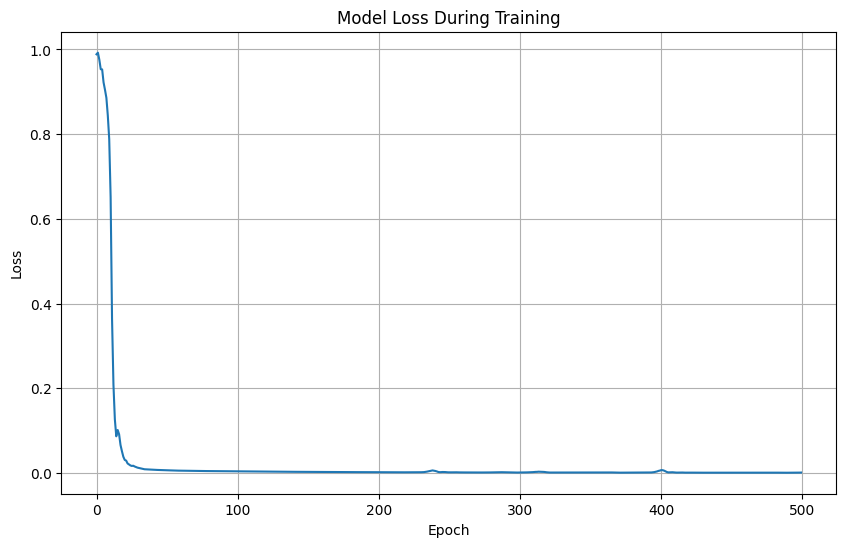

32/32 [==============================] - 0s 2ms/step


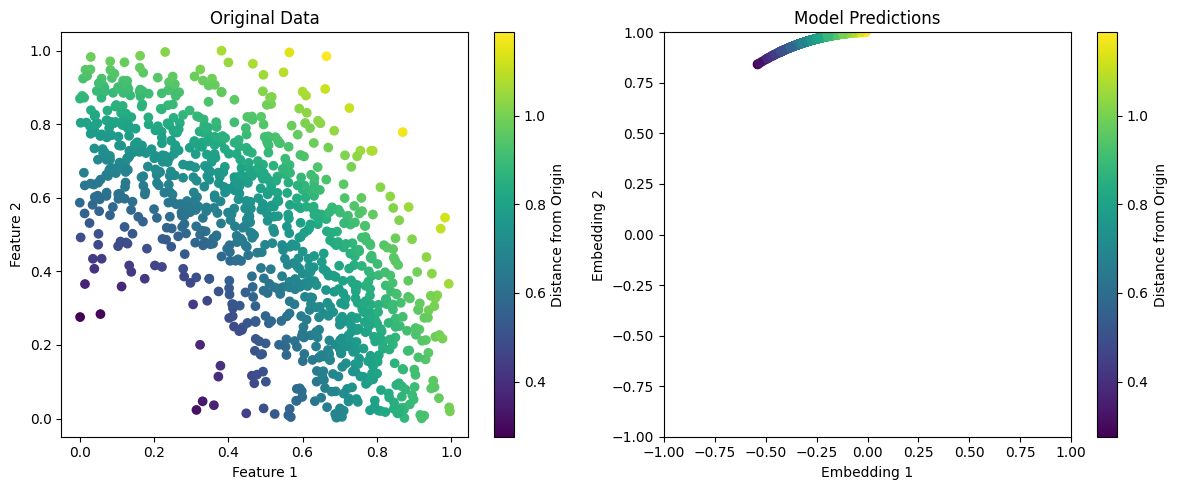

In [7]:
# Usage example with custom loss function
def custom_loss(y_true, y_pred):
    return mb.pdc_loss_linear_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


trainer = TrainerV2(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2, ae=False)
history, final_correlation = trainer.train(loss_fn=custom_loss, num_points=2000, epochs=500, batch_size=1024)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - 1s 97ms/step - loss: 1.0301
Epoch 2/500
2/2 [==============================] - 0s 17ms/step - loss: 1.0073
Epoch 3/500
2/2 [==============================] - 0s 18ms/step - loss: 0.9841
Epoch 4/500
2/2 [==============================] - 0s 16ms/step - loss: 0.9429
Epoch 5/500
2/2 [==============================] - 0s 17ms/step - loss: 

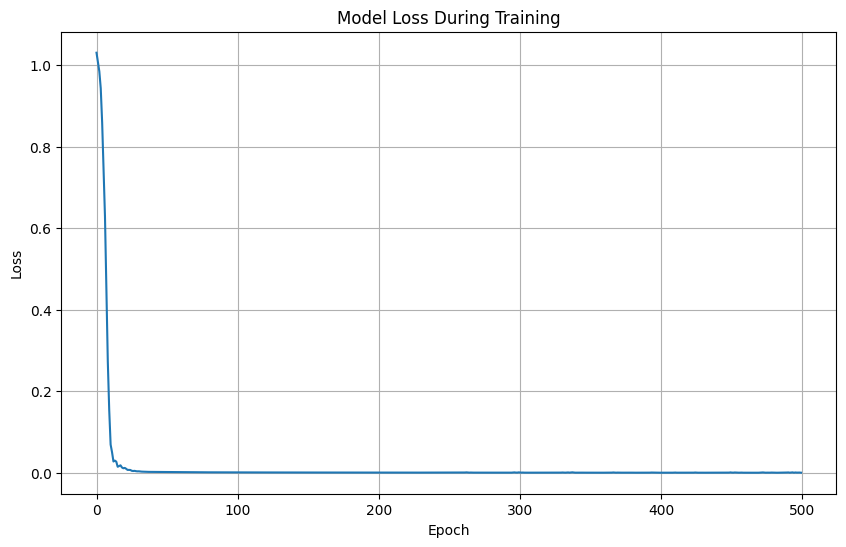

32/32 [==============================] - 0s 4ms/step


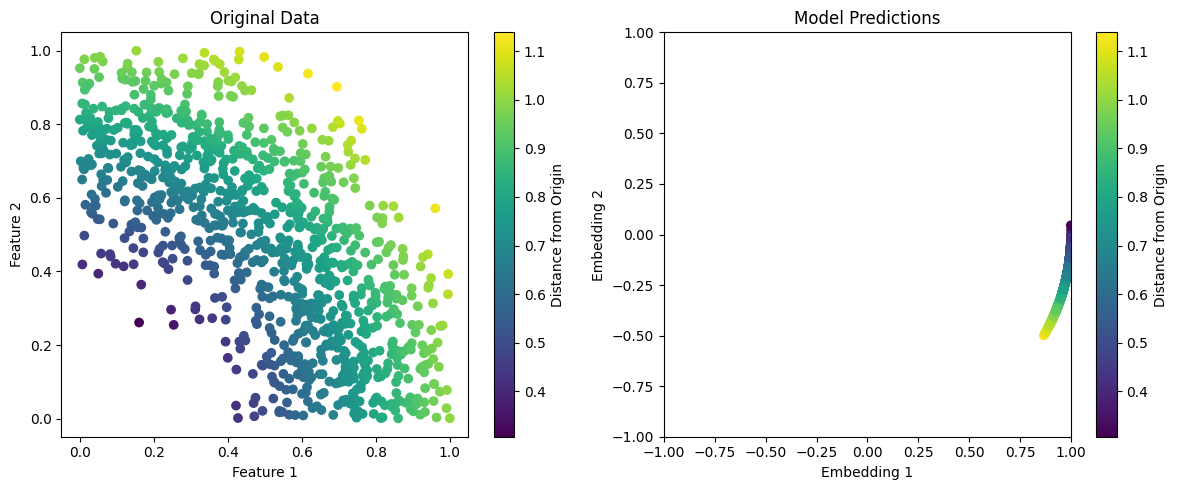

In [8]:
# Usage example with custom loss function
def custom_loss(y_true, y_pred):
    return mb.pdc_loss_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


trainer = TrainerV2(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2, ae=False)
history, final_correlation = trainer.train(loss_fn=custom_loss, num_points=2000, epochs=500, batch_size=1024)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

Epoch 1/500
2/2 [==============================] - 1s 33ms/step - loss: 0.5087
Epoch 2/500
2/2 [==============================] - 0s 32ms/step - loss: 0.1756
Epoch 3/500
2/2 [==============================] - 0s 30ms/step - loss: 0.0608
Epoch 4/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0224
Epoch 5/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0100
Epoch 6/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0058
Epoch 7/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0044
Epoch 8/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0039
Epoch 9/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0038
Epoch 10/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0038
Epoch 11/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0039
Epoch 12/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0040
Epoch 13/500
2/2 [==============================]

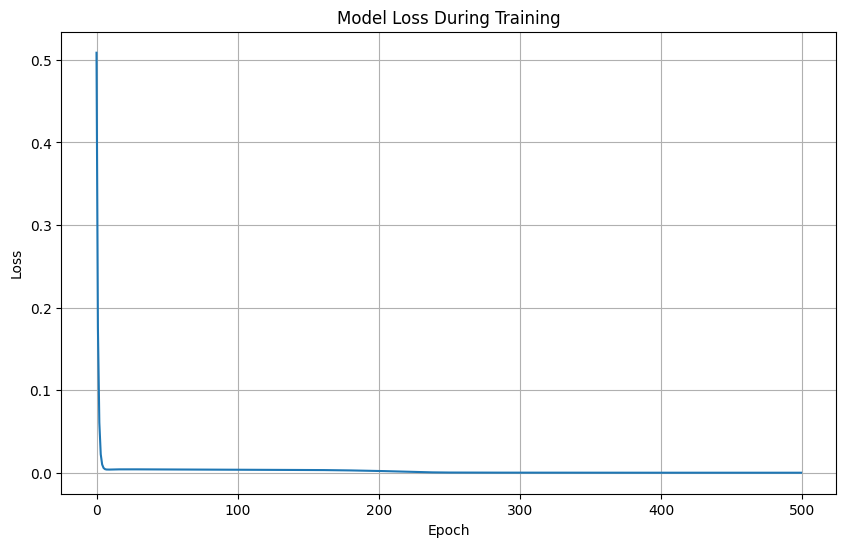

32/32 [==============================] - 0s 2ms/step


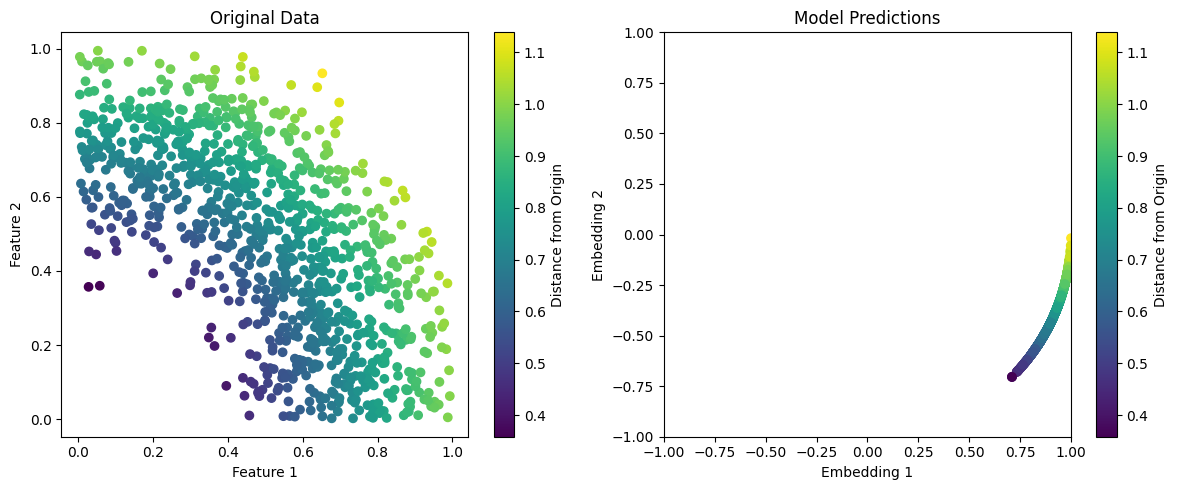

In [9]:
# Usage example with custom loss function
def custom_loss(y_true, y_pred):
    return mb.pds_loss_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


trainer = TrainerV2(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2, ae=False)
history, final_correlation = trainer.train(loss_fn=custom_loss, num_points=2000, epochs=500, batch_size=1024)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

Epoch 1/500
2/2 [==============================] - 1s 9ms/step - loss: 0.5315
Epoch 2/500
2/2 [==============================] - 0s 9ms/step - loss: 0.0051
Epoch 3/500
2/2 [==============================] - 0s 11ms/step - loss: 0.0068
Epoch 4/500
2/2 [==============================] - 0s 9ms/step - loss: 0.0087
Epoch 5/500
2/2 [==============================] - 0s 9ms/step - loss: 0.0094
Epoch 6/500
2/2 [==============================] - 0s 10ms/step - loss: 0.0093
Epoch 7/500
2/2 [==============================] - 0s 9ms/step - loss: 0.0087
Epoch 8/500
2/2 [==============================] - 0s 8ms/step - loss: 0.0079
Epoch 9/500
2/2 [==============================] - 0s 8ms/step - loss: 0.0070
Epoch 10/500
2/2 [==============================] - 0s 8ms/step - loss: 0.0062
Epoch 11/500
2/2 [==============================] - 0s 9ms/step - loss: 0.0057
Epoch 12/500
2/2 [==============================] - 0s 9ms/step - loss: 0.0052
Epoch 13/500
2/2 [==============================] - 0s 8ms/

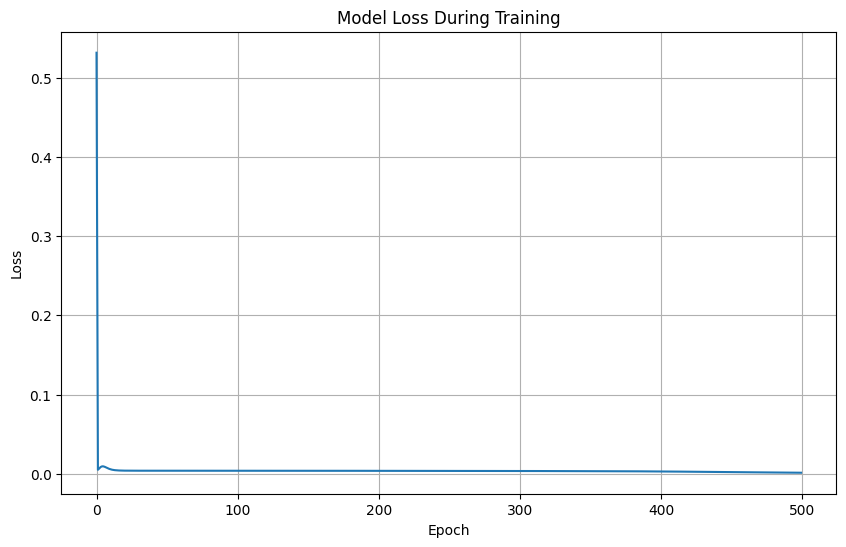

32/32 [==============================] - 0s 2ms/step


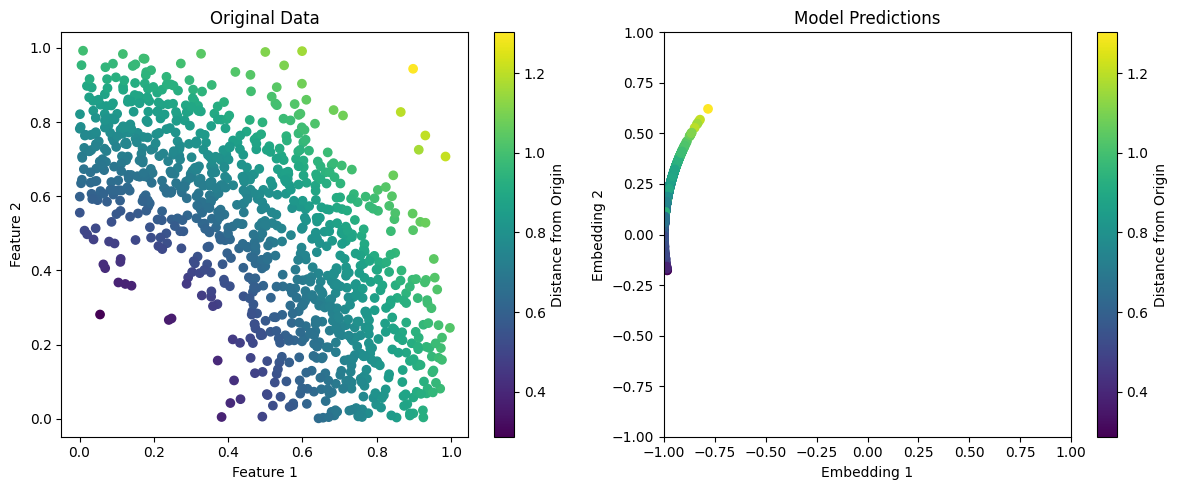

In [10]:
# Usage example with custom loss function
def custom_loss(y_true, y_pred):
    return mb.pds_loss_linear_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


trainer = TrainerV2(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2, ae=False)
history, final_correlation = trainer.train(loss_fn=custom_loss, num_points=2000, epochs=500, batch_size=1024)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

In [18]:


class TrainerV3:
    def __init__(self, input_dim=2, hidden_dims=None, output_dim=2, ae=False):
        if hidden_dims is None:
            hidden_dims = [64, 32]
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.ae = ae
        self.model = self.build_model()

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs
    
        # Hidden layers with Leaky ReLU activation
        for dim in self.hidden_dims:
            x = Dense(dim)(x)
            x = LeakyReLU()(x)
    
        # Output layer for normalized embedding
        embedding = Dense(self.output_dim)(x)
        normalized_embedding = tf.keras.layers.LayerNormalization(name='normalize_layer')(embedding)
        
        if self.ae:
            # Decoder layers - mirror the encoder architecture
            decoder_dims = self.hidden_dims[::-1]  # Reverse hidden dims
            x = normalized_embedding
            
            for dim in decoder_dims:
                x = Dense(dim)(x)
                x = LeakyReLU()(x)
            
            # Reconstruction output
            reconstruction = Dense(self.input_dim, activation='sigmoid', name='dense_reconstruction')(x)
            
            model = Model(inputs=inputs, outputs=[normalized_embedding, reconstruction], name='autoencoder_model')
        else:
            model = Model(inputs=inputs, outputs=normalized_embedding, name='embedding_model')
            
        return model

    def generate_synthetic_data(self, num_points=200):
        pool_size = num_points * 10
        features = np.random.uniform(0, 1, (pool_size, self.input_dim))
        
        distances = np.sqrt(np.sum(features**2, axis=1))
        weights = np.exp(-((distances - 0.75) ** 2) / (2 * 0.15 ** 2))
        weights = weights / np.sum(weights)
        
        selected_indices = np.random.choice(
            pool_size, 
            size=num_points, 
            p=weights,
            replace=False
        )
        
        selected_features = features[selected_indices]
        selected_distances = distances[selected_indices]
        
        return selected_features, selected_distances.reshape(-1, 1)

    def compute_pairwise_correlation(self, features, predictions):
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        correlation, _ = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation

    def train(self, loss_fn, num_points, epochs=1000, batch_size=32, verbose=1, reconstruction_weight=0.1):
        X_train, y_train = self.generate_synthetic_data(num_points=num_points)

        if self.ae:
            # Compile model with separate losses for embedding and reconstruction
            self.model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss={'normalize_layer': loss_fn, 'dense_reconstruction': 'mse'},
                loss_weights={'normalize_layer': 1.0, 'dense_reconstruction': reconstruction_weight}
            )

            # Prepare target data for training
            train_dataset = tf.data.Dataset.from_tensor_slices(
                (X_train, {"normalize_layer": y_train, "dense_reconstruction": X_train})
            ).batch(batch_size)
        else:
            self.model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=loss_fn
            )
            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)

        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose
        )

        if self.ae:
            predictions, reconstructions = self.model.predict(X_train)
            reconstruction_error = np.mean((X_train - reconstructions) ** 2)
            print(f"Average reconstruction error: {reconstruction_error:.6f}")
        else:
            predictions = self.model.predict(X_train)

        correlation = self.compute_pairwise_correlation(X_train, predictions)

        return history, correlation

    def plot_training_history(self, history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.title('Model Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    def plot_data_distribution(self, features, labels):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
        plt.colorbar(scatter, label='Distance from Origin')
        plt.title('Data Points Colored by Distance')
        plt.xlabel('X')
        plt.ylabel('Y')

        plt.subplot(1, 3, 2)
        plt.hist(labels, bins=30, density=True)

        x = np.linspace(0, np.sqrt(2), 100)
        target_dist = np.exp(-((x - 0.75) ** 2) / (2 * 0.15 ** 2))
        target_dist = target_dist / np.max(target_dist) * plt.gca().get_ylim()[1]
        plt.plot(x, target_dist, 'r--', label='Target Distribution')
        plt.legend()

        plt.title('Distribution of Distances')
        plt.xlabel('Distance from Origin')
        plt.ylabel('Density')

        plt.subplot(1, 3, 3)
        plt.scatter(features[:, 0], features[:, 1], alpha=0.5)

        for radius in [0.25, 0.5, 0.75, 1.0]:
            circle = plt.Circle((0, 0), radius, fill=False, color='red', alpha=0.3)
            plt.gca().add_artist(circle)

        plt.axis('equal')
        plt.title('Points with Reference Circles')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_predictions(self, features, labels, predictions):
        """Plot original data and model predictions."""
        # Check if the model is in AE mode and unpack predictions accordingly
        if self.ae:
            predictions, _ = predictions  # Unpack embedding predictions if in AE mode
    
        plt.figure(figsize=(12, 5))
    
        # Original data plot
        plt.subplot(1, 2, 1)
        plt.scatter(features[:, 0], features[:, 1], c=labels.flatten(), cmap='viridis', alpha=0.7)
        plt.colorbar(label='Distance from Origin')
        plt.title('Original Data')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
    
        # Predictions plot
        plt.subplot(1, 2, 2)
        
        # Check prediction range to set plot limits accordingly
        pred_min, pred_max = np.min(predictions, axis=0), np.max(predictions, axis=0)
        plt.scatter(predictions[:, 0], predictions[:, 1], c=labels.flatten(), cmap='viridis', alpha=0.7)
        plt.colorbar(label='Distance from Origin')
        plt.title('Model Predictions')
        plt.xlabel('Embedding 1')
        plt.ylabel('Embedding 2')
        
        # Adjust plot limits based on the data range for better visibility
        plt.xlim(pred_min[0] - 0.1, pred_max[0] + 0.1)
        plt.ylim(pred_min[1] - 0.1, pred_max[1] + 0.1)
        plt.tight_layout()
        plt.show()



Epoch 1/500
2/2 [==============================] - 1s 22ms/step - loss: 0.3448 - normalize_layer_loss: 0.3383 - dense_reconstruction_loss: 0.0649
Epoch 2/500
2/2 [==============================] - 0s 22ms/step - loss: 0.2500 - normalize_layer_loss: 0.2435 - dense_reconstruction_loss: 0.0648
Epoch 3/500
2/2 [==============================] - 0s 21ms/step - loss: 0.2110 - normalize_layer_loss: 0.2046 - dense_reconstruction_loss: 0.0647
Epoch 4/500
2/2 [==============================] - 0s 19ms/step - loss: 0.1857 - normalize_layer_loss: 0.1792 - dense_reconstruction_loss: 0.0647
Epoch 5/500
2/2 [==============================] - 0s 29ms/step - loss: 0.1483 - normalize_layer_loss: 0.1418 - dense_reconstruction_loss: 0.0647
Epoch 6/500
2/2 [==============================] - 0s 17ms/step - loss: 0.1110 - normalize_layer_loss: 0.1045 - dense_reconstruction_loss: 0.0647
Epoch 7/500
2/2 [==============================] - 0s 25ms/step - loss: 0.1022 - normalize_layer_loss: 0.0957 - dense_recons

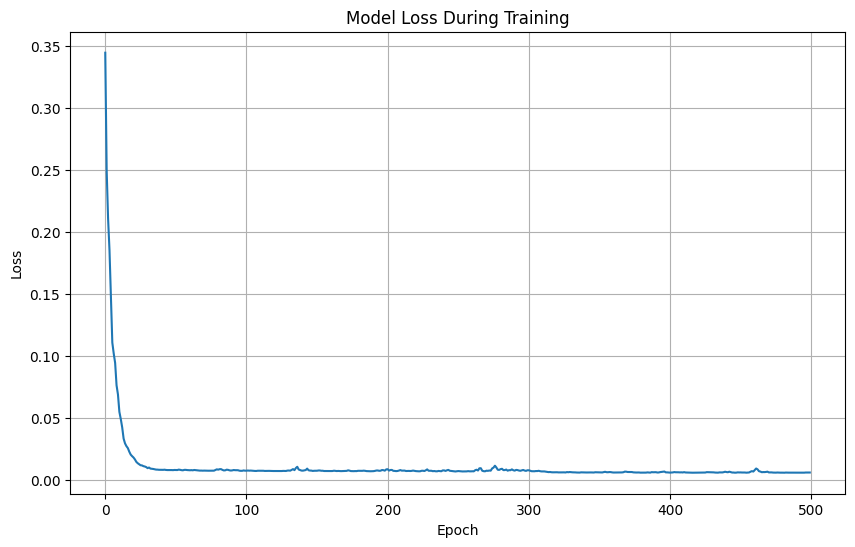

32/32 [==============================] - 0s 6ms/step


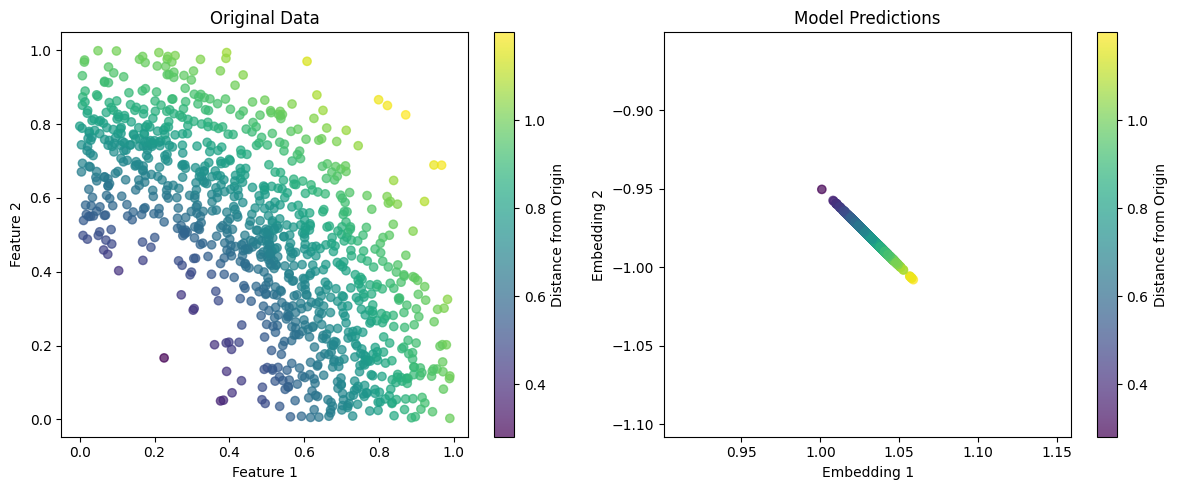

In [20]:
# Usage example with custom loss function
def custom_loss(y_true, y_pred):
    return mb.pdc_loss_linear_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


trainer = TrainerV3(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2, ae=True)
history, final_correlation = trainer.train(loss_fn=custom_loss, num_points=2000, epochs=500, batch_size=1024)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)